In [1]:
import matplotlib.pyplot as plt
#data manipulations
import numpy as np
import pandas as pd
#pytorch
import torchvision
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as f
#scraping from internet
from PIL import Image
#scraping from internet
import requests
from io import BytesIO
# time related
from timeit import default_timer as timer

In [2]:
# transforms for images
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(p = 0.5)
])


# datasets
trainset = torchvision.datasets.ImageFolder("../input/catdata/train", transform = transforms)
validset = torchvision.datasets.ImageFolder("../input/catdata/val", transform = transforms)
testset = torchvision.datasets.ImageFolder("../input/catdata/test", transform = transforms)

#batches
batch_size = 64

# loaders for data
trainloader = torch.utils.data.DataLoader(trainset , batch_size=batch_size , shuffle = True)
validloader = torch.utils.data.DataLoader(validset , batch_size=batch_size , shuffle = True)
testloader = torch.utils.data.DataLoader(testset  , batch_size=batch_size)

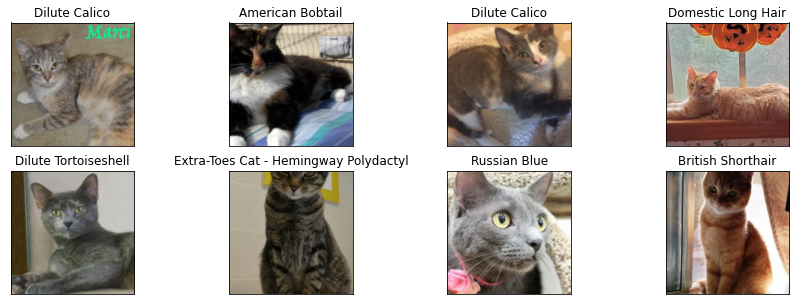

In [3]:
images, labels = iter(trainloader).next()
images, labels = images.numpy() , labels.numpy()

fig = plt.figure(figsize = (15,5))

for i in range(int(batch_size/8)):
    ax = fig.add_subplot(2 , int(batch_size/16) , i + 1 , xticks = [] , yticks = [])
    ax.imshow(np.transpose(images[i] , (1,2,0)) , cmap = 'gray')
    ax.set_title(trainset.classes[labels[i]])

In [4]:
# Single batch
print("number of train batches : ", len(trainloader))
print("number of validation batches : ", len(validloader))
print("Size of test batches : ", len(testloader))

number of train batches :  241

number of validation batches :  35

Size of test batches :  70


In [5]:
print("Unique classes number : ",len(trainset.classes))
print("Classes : ", trainset.classes)

Unique classes number :  55

Classes :  ['Abyssinian', 'American Bobtail', 'American Curl', 'American Shorthair', 'Applehead Siamese', 'Balinese', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Burmese', 'Calico', 'Chartreux', 'Cornish Rex', 'Devon Rex', 'Dilute Calico', 'Dilute Tortoiseshell', 'Domestic Long Hair', 'Domestic Medium Hair', 'Domestic Short Hair', 'Egyptian Mau', 'Exotic Shorthair', 'Extra-Toes Cat - Hemingway Polydactyl', 'Havana', 'Himalayan', 'Japanese Bobtail', 'Korat', 'Maine Coon', 'Manx', 'Munchkin', 'Nebelung', 'Norwegian Forest Cat', 'Ocicat', 'Oriental Short Hair', 'Oriental Tabby', 'Persian', 'Pixiebob', 'Ragamuffin', 'Ragdoll', 'Russian Blue', 'Scottish Fold', 'Selkirk Rex', 'Siamese', 'Siberian', 'Silver', 'Snowshoe', 'Sphynx - Hairless Cat', 'Tabby', 'Tiger', 'Tonkinese', 'Torbie', 'Tortoiseshell', 'Turkish Angora', 'Turkish Van', 'Tuxedo']


In [6]:
# Whether to train on a gpu
my_gpu = torch.cuda.is_available()
print(f'Train on gpu: {my_gpu}')
device = torch.device('cuda' if my_gpu else 'cpu')
print(f"my device: {torch.cuda.get_device_name(0)}")

Train on gpu: True

my device: Tesla T4


In [7]:
import torch.nn as nn

model = torchvision.models.mobilenet_v2(pretrained = False)  

#freeze model params

#for param in model.parameters():
#    param = param.requires_grad_(False)

#new layer
model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=len(trainset.classes))
print(model.classifier)
print(model.eval())


model = model.to(device) #Moving the model to GPU

Sequential(

  (0): Dropout(p=0.2, inplace=False)

  (1): Linear(in_features=1280, out_features=55, bias=True)

)

MobileNetV2(

  (features): Sequential(

    (0): ConvNormActivation(

      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

      (2): ReLU6(inplace=True)

    )

    (1): InvertedResidual(

      (conv): Sequential(

        (0): ConvNormActivation(

          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)

          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

          (2): ReLU6(inplace=True)

        )

        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)

        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

      )

    )

    (2): InvertedResidual(

      (conv): Sequential(

        (0): Con

In [8]:
lr = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters() , lr = lr)

In [9]:
#format class

class color_formats:
    """
    Simple color formating:
    Variables:
        >OKCYAN - cyan printing.
        >Bold - bold printing.
        >UNDERLINE - underline printing.
    """
    OKCYAN = '\033[96m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [10]:
def train_loop(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_model_name,
          max_epochs_stop=100,
          num_epochs=100,
          num_epochs_report=1):
    """Train a neural network Model
    Args
    --------
        >model (Pytorch nn model): The neural network for the training process.  
        >criterion (Pytorch loss function): Initialize the loss function.
        >optimizer (Pytorch optimizer): Use an optimizer to compute gradients to update the weights.
        >train_loader (Pytorch dataloader): training dataloader to iterate through.
        >valid_loader (Pytorch dataloader): validation dataloader used for early stopping.
        >save_model_name (str): file path to save the model state dict, file name ends with 'pt.'.
        >max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping.
        >num_epochs (int): maximum number of training epochs if the early stopping is not activated.
        >num_epochs_report (int): frequency of epochs to print training reports.
    
    outputs
    --------
        >model (PyTorch model): Trained neural networks with best weights.
        >history (DataFrame): History of train and validation loss and accuracy.
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf  

    valid_max_acc = 0
    history = []

    # Number trained epochs  (while using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'{color_formats.BOLD + color_formats.UNDERLINE}Training activated:{color_formats.ENDC}\n')

    overall_start = timer()

    # Start of loop
    for epoch in range(num_epochs):

        # Track of training and validation loss for each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set model to train
        model.train()
        
        #start timer
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Put the data in the gpu
            if my_gpu:
                data, target = data.to(device), target.to(device)

            # Remove past gradients
            optimizer.zero_grad()
            # Predicted outputs as log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target.long())
            loss.backward()

            # Update the weights
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Training progress tracker
            print(
                f'Epoch: {epoch+1}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')


        # Start validation after training loops ends.
        else:
            model.epochs += 1

            # Deactivate the gradient tracking. 
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Put the data in the gpu
                    if my_gpu:
                        data, target = data.to(device), target.to(device)

                    # Predicted outputs as log probabilities
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target.long())
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate accuracy of validation set
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results for the num_epochs_report that was set
                if (epoch + 1) % num_epochs_report == 0:
                    print(
                        f'\n\nEpoch: {color_formats.BOLD}{epoch+1}{color_formats.ENDC} \tTraining Loss: {color_formats.BOLD}{train_loss:.4f}{color_formats.ENDC} \tValidation Loss: {color_formats.BOLD}{valid_loss:.4f}{color_formats.ENDC}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {color_formats.BOLD}{100 * train_acc:.2f}%{color_formats.ENDC}\t Validation Accuracy: {color_formats.BOLD}{100 * valid_acc:.2f}%{color_formats.ENDC}\n'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_model_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch + 1

                # Otherwise count all consecutive epochs with no improvement.
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\n\n{color_formats.OKCYAN}Early stopping activated!{color_formats.ENDC}\nthe validation loss has not improved for {max_epochs_stop} epochs.\n\n{color_formats.BOLD + color_formats.UNDERLINE}End of training report:{color_formats.ENDC}\n\n\t-Total epochs: {epoch+1} \n\t-Best epoch: {color_formats.BOLD}{best_epoch}{color_formats.ENDC} \n\t-loss: {color_formats.BOLD}{valid_loss_min:.2f}{color_formats.ENDC} \n\t-accuracy: {color_formats.BOLD}{100 * valid_best_acc:.2f}%\n{color_formats.ENDC}'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_model_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # History update
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history


    # Record overall time and print out Report
    total_time = timer() - overall_start
    print(
        f'\nBest epoch is epoch #{best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # History update
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [11]:
# Start Training
# Running the model
model, history = train_loop(
    model,
    criterion,
    optimizer,
    trainloader,
    validloader,
    save_model_name="./mobilenetv2_cat_scratch.pt",
    max_epochs_stop=100,
    num_epochs=100,
    num_epochs_report=1)

Training activated:



Epoch: 1	100.00% complete. 186.27 seconds elapsed in epoch.



Epoch: 1 	Training Loss: 3.7047 	Validation Loss: 3.5909

		Training Accuracy: 8.23%	 Validation Accuracy: 10.88%



Epoch: 2	100.00% complete. 149.86 seconds elapsed in epoch.



Epoch: 2 	Training Loss: 3.5289 	Validation Loss: 3.5495

		Training Accuracy: 11.14%	 Validation Accuracy: 10.75%



Epoch: 3	100.00% complete. 147.32 seconds elapsed in epoch.



Epoch: 3 	Training Loss: 3.4506 	Validation Loss: 3.4878

		Training Accuracy: 12.82%	 Validation Accuracy: 11.34%



Epoch: 4	100.00% complete. 147.05 seconds elapsed in epoch.



Epoch: 4 	Training Loss: 3.3744 	Validation Loss: 3.4555

		Training Accuracy: 14.75%	 Validation Accuracy: 14.22%



Epoch: 5	100.00% complete. 147.37 seconds elapsed in epoch.



Epoch: 5 	Training Loss: 3.3027 	Validation Loss: 3.3496

		Training Accuracy: 15.97%	 Validation Accuracy: 14.49%



Epoch: 6	100.00% complete. 147.58 seconds elapsed in epoch.



Epoch: 6 	

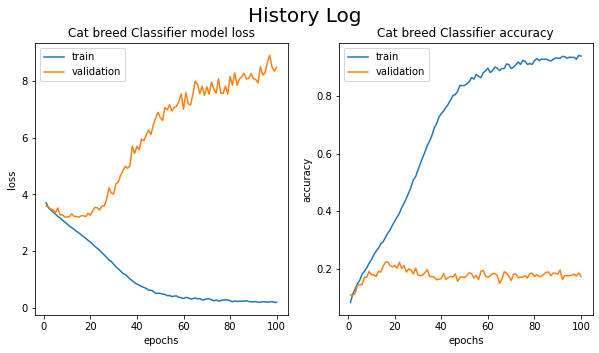

In [12]:
#models logs in detail over time of training.

history.index = [idx for idx in range(1, history.shape[0]+1)] #from first epoch
fig, axs = plt.subplots(1, 2, figsize = (10,5))
fig.suptitle('History Log',  size = 20)
#ethnicity model log

axs[0].plot(history["train_loss"], label = "train")
axs[0].plot(history["valid_loss"], label = "validation")
axs[0].set_xlabel("epochs")
axs[0].set_ylabel("loss")
axs[0].legend()
axs[0].set_title('Cat breed Classifier model loss')

axs[1].plot(history["train_acc"], label = "train")
axs[1].plot(history["valid_acc"], label = "validation")
axs[1].set_xlabel("epochs")
axs[1].set_ylabel("accuracy")
axs[1].legend()
axs[1].set_title('Cat breed Classifier accuracy')


plt.show()

In [13]:
def Accuracy_report(loader = None, model = None, n_classes = None):
    """
    Args:
    >loader (pytorch dataloader): the data for accuracy testing.
    >model (pytorch model) : the neural network.
    >n_classes (int): the number of classes.
    
    Output: 
    > class_acc (dict) : accuracy per classes. non existant taregts in the test set are set to nan value.
    > acc (float): overall accuracy.
    """
    my_classes = []

    classes = [n_class for n_class in range(n_classes)]
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    with torch.no_grad():
        for data in loader:
            inputs, targets = data 
            inputs = inputs.to(device)
            targets = targets.to(device)           
            outputs = model(inputs)    
            _, predictions = torch.max(outputs, 1)

            # collect the correct predictions for each class
            for target, prediction in zip(targets, predictions):
                if target == prediction:
                    correct_pred[classes[target]] += 1
                total_pred[classes[target]] += 1

    for classname, correct_count in correct_pred.items():
        try:
            accuracy = 100 * float(correct_count) / total_pred[classname]

            my_classes.append(accuracy)
        except ZeroDivisionError:
            my_classes.append(np.nan)
            continue
    
    acc =  round(100 * float(sum(correct_pred.values())/sum(total_pred.values())),2)
    class_acc = dict(zip(classes,[round(mc,2) for mc in my_classes]))
    return class_acc, acc

def test_report(class_acc,acc):
    """
    Args:
        > my_classes (dict) : accuracy per classes. non existant taregts in the test set are set to nan value.
        > acc (float): overall accuracy.
    
    Output:
        >report of test performance.
    """    
    print(f"{color_formats.BOLD + color_formats.UNDERLINE}Test Accuracy Report{color_formats.ENDC}")
    for key,value in class_acc.items():
        print(f"Class {trainset.classes[key]} has achived {color_formats.BOLD}{value}%{color_formats.ENDC} accuracy\n")
    print(f"Overall accuracy: {color_formats.BOLD}{acc}%{color_formats.ENDC}")

In [14]:
m1_test_class_acc, m1_test_acc = Accuracy_report(loader = testloader,model = model, n_classes = 55)
test_report(m1_test_class_acc,m1_test_acc)

Test Accuracy Report

Class Abyssinian has achived 1.92% accuracy



Class American Bobtail has achived 6.78% accuracy



Class American Curl has achived 0.0% accuracy



Class American Shorthair has achived 5.36% accuracy



Class Applehead Siamese has achived 7.14% accuracy



Class Balinese has achived 11.54% accuracy



Class Bengal has achived 8.51% accuracy



Class Birman has achived 4.26% accuracy



Class Bombay has achived 4.44% accuracy



Class British Shorthair has achived 11.3% accuracy



Class Burmese has achived 2.86% accuracy



Class Calico has achived 27.27% accuracy



Class Chartreux has achived 0.0% accuracy



Class Cornish Rex has achived 0.0% accuracy



Class Devon Rex has achived 0.0% accuracy



Class Dilute Calico has achived 31.41% accuracy



Class Dilute Tortoiseshell has achived 13.89% accuracy



Class Domestic Long Hair has achived 18.48% accuracy



Class Domestic Medium Hair has achived 0.0% accuracy



Class Domestic Short Hair has achived 7.04% a

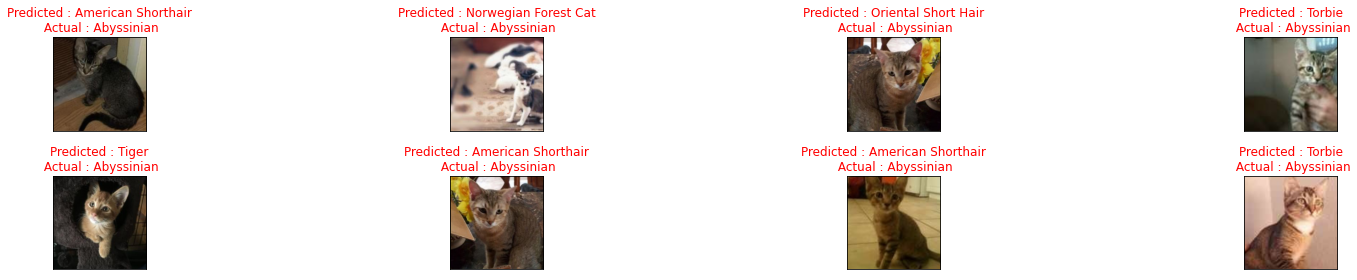

In [15]:
dataiter = iter(testloader)
images, labels = dataiter.next()
# get predictions
preds = np.squeeze(model(images.cuda()).data.max(1, keepdim=True)[1].cpu().numpy())
images = images.cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(int(batch_size/8)):
    ax = fig.add_subplot(2, int(batch_size/16), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx].transpose(1,2,0)), cmap='gray')
    ax.set_title("Predicted : {}\n Actual : {}".format(trainset.classes[preds[idx]], trainset.classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))
plt.tight_layout()

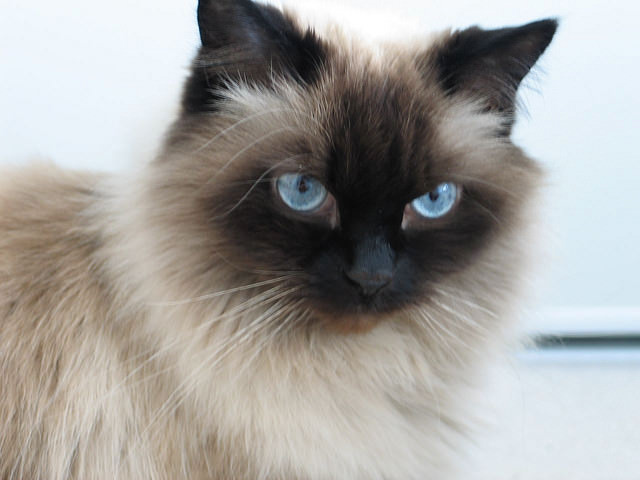

In [16]:
import requests
from io import BytesIO
url = "http://iheartcats.com/wp-content/uploads/2015/03/6820026_2b3966c52d_z.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img

In [17]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(p = 0.5)
])


def predictor(img, n=5):
    """
    Args: 
        >img - the image to predict.
        >n - number of top probabilities.
    
    Outputs:
        >pred - the top prediction.
        > top preds - top n predictions.
    """
    #transform the image
    img = transforms(img)
    # get the class predicted 
    pred = int(np.squeeze(model(img.unsqueeze(0).cuda()).data.max(1, keepdim=True)[1].cpu().numpy()))
    # the number is also the index for the class label
    pred = trainset.classes[pred]
    # get model log probabilities
    preds = torch.from_numpy(np.squeeze(model(img.unsqueeze(0).cuda()).data.cpu().numpy()))
    # convert to prediction probabilities of the top n predictions
    top_preds = torch.topk(torch.exp(preds),n)
    #display at an orgenized fasion
    top_preds = dict(zip([trainset.classes[i] for i in top_preds.indices],[f"{round(float(i)*100,2)}%" for i in top_preds.values]))
    return pred, top_preds

In [18]:
my_prediction, top_predictions = predictor(img, n=5)
print(my_prediction)
#print(top_predictions)

Himalayan


In [19]:
torch.save(model,"mobilenetv2_cat_scratch.pb")

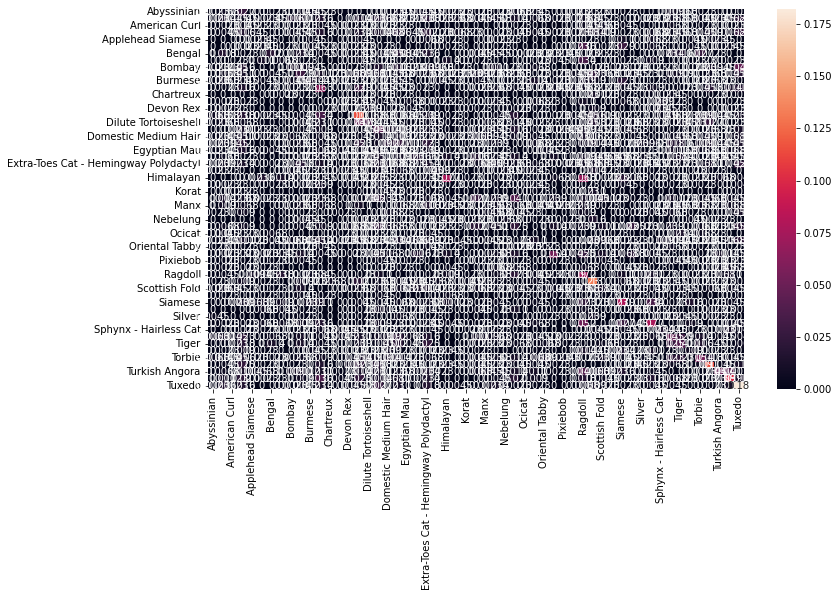

In [20]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []


# iterate over test data
for images, labels in testloader:
        output = np.squeeze(model(images.cuda()).data.max(1, keepdim=True)[1].cpu().numpy())
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = trainset.classes

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('./confusion_mobilenetv2.png')

In [21]:
from sklearn.metrics import accuracy_score, classification_report

# print accuracy
print("Overall Accuracy: ", round(accuracy_score(y_true, y_pred)*100,2)," %")

# print precision, recall, F1-score per each class/tag
print(classification_report(y_true, y_pred,target_names=trainset.classes))

Overall Accuracy:  16.44  %

                                       precision    recall  f1-score   support



                           Abyssinian       0.04      0.02      0.03        52

                     American Bobtail       0.06      0.05      0.05       118

                        American Curl       0.00      0.00      0.00        31

                   American Shorthair       0.04      0.06      0.05       112

                    Applehead Siamese       0.06      0.04      0.04        28

                             Balinese       0.04      0.04      0.04        52

                               Bengal       0.21      0.10      0.13        94

                               Birman       0.10      0.06      0.08        47

                               Bombay       0.13      0.06      0.08        90

                    British Shorthair       0.10      0.11      0.11       115

                              Burmese       0.16      0.09      0.11        70

         

In [22]:
from sklearn.metrics import roc_auc_score

def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [23]:
#ROC_AUC score
roc_auc_dict = roc_auc_score_multiclass(y_true, y_pred)
final_roc_auc_dictionary=dict(zip(list(trainset.classes) ,list(roc_auc_dict.values())) )
final_roc_auc_dictionary

{'Abyssinian': 0.5066534342850132,
 'American Bobtail': 0.51397334713417,
 'American Curl': 0.49648526077097505,
 'American Shorthair': 0.5103444790944791,
 'Applehead Siamese': 0.5159310155061345,
 'Balinese': 0.513990395569343,
 'Bengal': 0.5440766192385064,
 'Birman': 0.5288425222014546,
 'Bombay': 0.5238706299956588,
 'British Shorthair': 0.5434611750989969,
 'Burmese': 0.5391966532666601,
 'Calico': 0.6091475829642534,
 'Chartreux': 0.4995478182229256,
 'Cornish Rex': 0.5124700084300629,
 'Devon Rex': 0.5155842391304347,
 'Dilute Calico': 0.6444417018220985,
 'Dilute Tortoiseshell': 0.5651748852475831,
 'Domestic Long Hair': 0.5779364571565677,
 'Domestic Medium Hair': 0.4905941729754531,
 'Domestic Short Hair': 0.5278315625317384,
 'Egyptian Mau': 0.5032689006917179,
 'Exotic Shorthair': 0.5325853174122606,
 'Extra-Toes Cat - Hemingway Polydactyl': 0.509460696960697,
 'Havana': 0.5502468412685131,
 'Himalayan': 0.6325139775069366,
 'Japanese Bobtail': 0.4979610330765745,
 'Korat'